<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/04%20-%20ML/05_kmeans_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')

host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение

In [ ]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

## Задача 1. Выгрузка данных


Для этой задачи выгрузим следующие данные (чтобы не путаться, назовите признаки так, как указано в скобках):

1. Все поля из таблицы `user_passports`(оставьте названия из таблицы)

2. Из таблицы `live_adverts` агрегированные по `passport_id` характеристики:

- количество уникальных объявлений (n_ads)

- дата создания первого объявления (first_ad)

- средняя цена автомобиля из объявления (mean_price)

- средний год выпуска автомобиля из объявления (для того, чтобы посчитать среднее поля `year`, нужно сначала преобразовать тип поля в `int`) (mean_year)

Отфильтруйте регион = 'Омск', значения цены > 1000 и значение года != '0', чтобы избежать экстремальных значений.

3. Из таблицы `user_transactions` агрегированные по `passport_id` характеристики:

- количество уникальных типов транзакций пользователя `type` (n_types)

- сумма `sign` - знаков транзакции. Это нужно для того, чтобы определить, пользователь чаще выступал в качестве продавца (положительный знак суммы) или покупателя (отрицательный знак суммы) (top_type)

- среднее значение `balance_consumption` - средняя сумма транзакции пользователя (mean_transaction)

С помощью INNER JOIN по passport_id присоедините к user_passports остальные таблицы.

Отфильтруйте по execution_date = '2023-01-31' (последняя актуальная версия). В итоге наша таблица будет содержать агрегированные по пользователю данные на 2023-01-31

Сколько наблюдений в полученном датасете?

In [ ]:
#
sql = """
WITH passport_id_data as (
  SELECT
    passport_id,
    count(DISTINCT advert_id) AS n_ads,
    min(created_at) as first_ad,
    avg(price) as mean_price,
    avg(year :: int) as mean_year
  FROM
    live_adverts
  WHERE
    region = 'Омск'
    and year != '0'
    AND price > 1000
  GROUP BY
    passport_id
),

transaction_data AS (
    SELECT
      passport_id,
      uniqExact(type) as n_types,
      (case when sum(sign) < 0 then -1 when sum(sign) = 0 then 0 else 1 end) as top_type,
      avg(balance_consumption) AS mean_transaction
    FROM
      user_transactions
    GROUP BY
      passport_id
  )

SELECT
  up.*,
  pid.n_ads,
  pid.first_ad,
  pid.mean_price,
  pid.mean_year,
  td.n_types,
  td.top_type,
  td.mean_transaction
FROM
  user_passports up
  INNER JOIN passport_id_data pid ON up.passport_id = pid.passport_id
  INNER JOIN transaction_data td on td.passport_id = up.passport_id
WHERE
  up.execution_date = '2023-01-31'
"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
print(f"в датасете {data.shape[0]} записей")

в датасете 30703 записей


In [ ]:
data.columns = [_.split('.')[1] for _ in data.columns]

In [ ]:
data.execution_date = pd.to_datetime(data.execution_date)
data.first_ad = pd.to_datetime(data.first_ad)
data.created_at = pd.to_datetime(data.created_at)
data.user_type_cars_changed_at = pd.to_datetime(data.user_type_cars_changed_at)
data.user_type_changed_at = pd.to_datetime(data.user_type_changed_at)

In [ ]:
data.head()

,execution_date,passport_id,global_id,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,n_ads,first_ad,mean_price,mean_year,n_types,top_type,mean_transaction
0,2023-01-31,136749459,141545244,2020-01-02 22:39:54,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-02-02 13:08:49,560000.000000,2002.000000,1,1,0.000000
1,2023-01-31,134387629,137787302,2019-03-05 15:55:54,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-05-01 11:20:17,100000.000000,1993.000000,1,1,0.000000
2,2023-01-31,135129101,139293451,2019-06-04 23:17:10,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-08-03 19:10:09,720000.000000,2007.000000,5,1,53.995633
3,2023-01-31,141081287,145779441,2021-04-13 23:02:40,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-05-03 07:42:32,119166.666667,2000.666667,1,1,0.000000
4,2023-01-31,131931773,134644283,2018-06-19 17:19:34,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-01-28 04:39:53,157804.878049,1996.512195,4,1,68.571429


## Задача 2. EDA и Обработка выбросов (1/4)


Создайте признак `days_ago` типа `int`, который содержит количество полных дней, которое прошло с даты первого размещения объявления (из first_ad возьмите только дату) до "сегодняшнего дня" (execution_date) по каждому пользователю.

Какая медиана у полученного признака? Введите значение, округлив до целого

In [ ]:
data['days_ago'] = (data.execution_date.dt.date	 - data.first_ad.dt.date).apply(lambda x: x.days)

In [ ]:
print(f"медиана у полученного признака = {data.days_ago.median():.0f}")

медиана у полученного признака = 269


## Задача 2. EDA и Обработка выбросов (2/4)


Создайте признак `mean_n_years`, означающий средний возраст автомобилей, размещенных пользователем.

Для расчёта можно просто вычесть mean_year из 2023 (года execution_date).

Какое максимальное значение у полученного признака? Введите значение, округлив до целого

In [ ]:
data['mean_n_years'] = data.execution_date.dt.year - data.mean_year

In [ ]:
print(f"максимальное значение у полученного признака = {data.mean_n_years.max():.0f}")

максимальное значение у полученного признака = 73


## Задача 2. EDA и Обработка выбросов (3/4)


Создайте признак `buyer`, который принимает значение 1, если пользователь чаще покупал, чем продавал, и 0 иначе.

Сколько пользователей чаще были покупателями?

In [ ]:
data["buyer"] = (data.top_type == -1).astype(int)

In [ ]:
print(f"{data.buyer.sum()} пользователей чаще были покупателями")

7859 пользователей чаще были покупателями


## Задача 2. EDA и Обработка выбросов (4/4)


Продолжим подготовку данных:

1) Отсортируйте датафрейм по passport_id.

2) Прологарифмируйте среднюю цену, как мы это делали в прошлом ДЗ, чтобы распределение было более симметричным.

Для кластеризации пользователей будем использовать следующие признаки:

* количество размещенных объявлений
* количество уникальных типов транзакций пользователя
* количество дней, которое прошло с даты первого размещения объявления до сегодняшнего дня
* логарифм средней цены автомобилей из объявлений пользователя
* средний возраст автомобилей из объявлений пользователя
* является ли пользователь покупателем чаще, чем продавцом

3) Обрежьте следующие признаки по 99 квантилю (оставить все, что строго меньше), чтобы удалить выбросы:

* количество размещенных объявлений
* средний возраст автомобилей из объявлений пользователя
* количество дней, которое прошло с даты первого размещения объявления до сегодняшнего дня
4) Отмасшабируйте все признаки с помощью StandardScaler

Сколько сейчас осталось наблюдений?

In [ ]:
data.sort_values(by='passport_id', inplace=True)

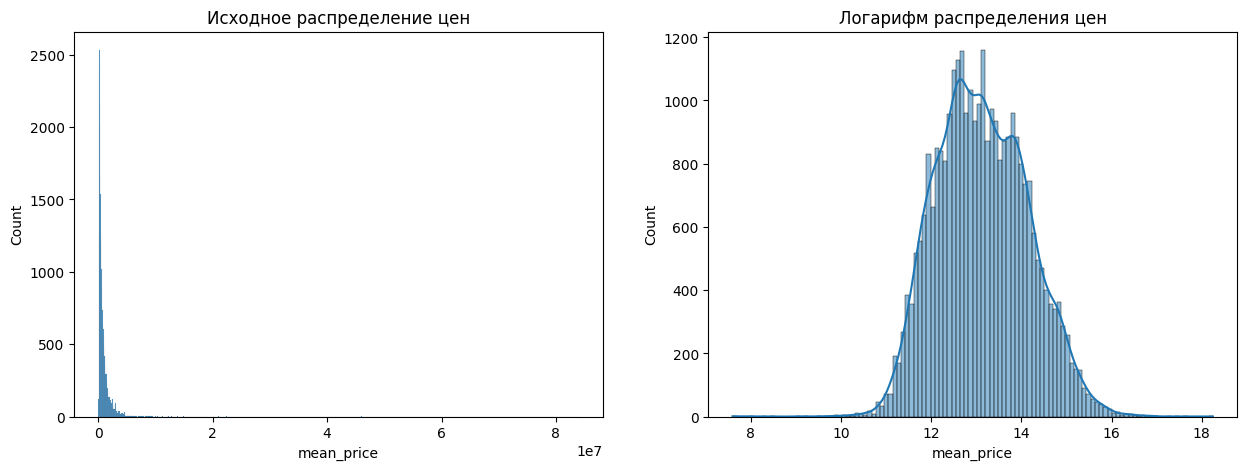

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data.mean_price, ax=axes[0]).set_title('Исходное распределение цен')
sns.histplot(np.log(data.mean_price), ax=axes[1], kde=True).set_title('Логарифм распределения цен')
plt.show()

In [ ]:
data["mean_log_price"] = np.log(data.mean_price)

In [ ]:
df = data[["n_ads", "n_types", "days_ago", "mean_log_price", "mean_n_years", "buyer"]]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


In [ ]:
cols_for_outliers_removing = ["n_ads", "mean_n_years", "days_ago"]

In [ ]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        selected_cols=list(),
        outliers_quantiles=[0.00, 0.99]
    ):
        self.selected_cols = selected_cols
        self.outliers_quantiles = outliers_quantiles

    def fit(self, X):

        return self

    def transform(self, X):
        if not hasattr(X, "iloc"):
            raise ValueError(
                "CustomTransformer can only be applied to pandas dataframes in X argument"
            )
        X_copy = X.copy()

        self.index = X_copy.index

        for col in self.selected_cols:
            if self.outliers_quantiles[0] == 0:
                filtered_index = X_copy[col].loc[X_copy[col] < X_copy[col].quantile(self.outliers_quantiles[1])].index
            elif self.outliers_quantiles[1] == 1:
                filtered_index = X_copy[col].loc[X_copy[col] > X_copy[col].quantile(self.outliers_quantiles[0])].index
            else:
                filtered_index = X_copy[col].loc[(X_copy[col] > X_copy[col].quantile(self.outliers_quantiles[0])) & (X_copy[col] < X_copy[col].quantile(self.outliers_quantiles[1]))].index

            self.index = self.index.intersection(filtered_index)

        return X_copy.loc[self.index]

    def inverse_transform(self):
        pass

In [ ]:
col_transformer = ColumnTransformer(
    transformers=[
        ('StandardScaler', StandardScaler(), selector(dtype_include="number"))
    ],
    verbose_feature_names_out=False   # Оставляем оригинальные названия колонок
).set_output(transform='pandas')

In [ ]:
final_process_pipe = Pipeline(
    [
        ("custom_transformer", CustomTransformer(selected_cols=cols_for_outliers_removing, outliers_quantiles=[0.00, 0.99])),
        ("col_transformer", col_transformer)
    ]
)

In [ ]:
df_ = final_process_pipe.fit(df).transform(df)

In [ ]:
print(f"Осталось {df_.shape[0]} наблюдений")

Осталось 29763 наблюдений


## Задача 3. Обучение DBSCAN (1/3)


Подберите параметр eps для алгоритма DBSCAN по метрике silhouette_score подобно тому, как это было сделано на лекции. Для DBSCAN  зафиксируйте n_jobs=1.

Перебор eps сделайте по следующей сетке: `[0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 4, 5]`

Остальные параметры оставьте дефолтными (всего получится 11 комбинаций).

Также оставим ограничение на расчет silhouette_score, как мы делали в лекции, будем его считать, только если разбиение получилось на 3 и более кластеров.

Какой eps подобрал алгоритм? Введите полученное значение, округлив до одного знака после запятой, если это требуется. В качестве разделителя используйте точку

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
eps_grid = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 4, 5]

In [ ]:
dbscan = DBSCAN(n_jobs=1)

In [ ]:
silhouettes = []
for eps in eps_grid:
    dbscan.eps = eps
    labels = dbscan.fit_predict(df_)
    if len(set(labels)) >= 3:
        silhouette_ = silhouette_score(df_, labels)
        silhouettes.append(silhouette_)
    else:
        silhouettes.append(-100)
print(f"Достигается при параметрах eps = {eps_grid[silhouettes.index(max(silhouettes))]}")

Лучшее значение выбранной метрики равно 0.23877790704382365
Достигается при параметрах 1.5


In [ ]:
print(f"Лучшее значение выбранной метрики равно {max(silhouettes)}")
print(f"Достигается при параметрах eps = {eps_grid[silhouettes.index(max(silhouettes))]}")

Лучшее значение выбранной метрики равно 0.23877790704382365
Достигается при параметрах eps = 1.5


## Задача 3. Обучение DBSCAN (2/3)


Давайте поразмышляем: полезно ли для нас разделение на 3 кластера, которые сильно отличаются по размеру? Разумно ли выделять отдельный кластер для нескольких десятков пользователей?

Через запятую и пробел напишите, сколько наблюдений содержит каждый кластер, в порядке возрастания лейблов кластеров.

In [ ]:
dbscan.eps = eps_grid[silhouettes.index(max(silhouettes))]
labels = dbscan.fit_predict(df_)

In [ ]:
unique, counts = np.unique(labels, return_counts=True)

In [ ]:
print(np.asarray((unique, counts)).T)

[[   -1    31]
 [    0 22230]
 [    1  7502]]


Кластеризация ведет себя не совсем так, как мы ожидали. Это и понятно: для алгоритма существует только метрика расстояния, у него нет понимания о смысле фичей. Поэтому часто в задачах кластеризации нужно опираться еще и на бизнес-интуицию. Раз нам не подошел DBSCAN, давайте обратимся к алгоритму Kmeans.

## Задача 4. Обучение K-MEANS (1/8)


С помощью все того же silhouette_score найдите оптимальное количество кластеров для алгоритма Kmeans в диапазоне от `3 до 10`. Для воспроизводимости в Kmeans используйте гиперпараметры `random_state=42` и `n_init=1`.

Для отслеживания прогресса удобно оборачивать цикл в `tqdm`, как мы делали в модулях по экспериментам.

Каково оптимальное кол-во кластеров для Kmeans согласно `silhouette_score`?

In [ ]:
model_params = list(range(3, 11))
from tqdm.notebook import tqdm

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(random_state=42, n_init=1)

In [ ]:
results = []
for i in tqdm(model_params):
    kmeans.set_params(n_clusters=i)
    labels = kmeans.fit_predict(df_)
    results.append(silhouette_score(df_, labels))
    print(f"n_clusters = {i}, silhouette_score = {silhouette_score(df_, labels)}")

  0%|          | 0/8 [00:00<?, ?it/s]

n_clusters = 3, silhouette_score = 0.2078370891959299
n_clusters = 4, silhouette_score = 0.2582064653420615
n_clusters = 5, silhouette_score = 0.24758902167248648
n_clusters = 6, silhouette_score = 0.25357512575681446
n_clusters = 7, silhouette_score = 0.21949184393164825
n_clusters = 8, silhouette_score = 0.2055420599186093
n_clusters = 9, silhouette_score = 0.2065724087757851
n_clusters = 10, silhouette_score = 0.20165098723579025


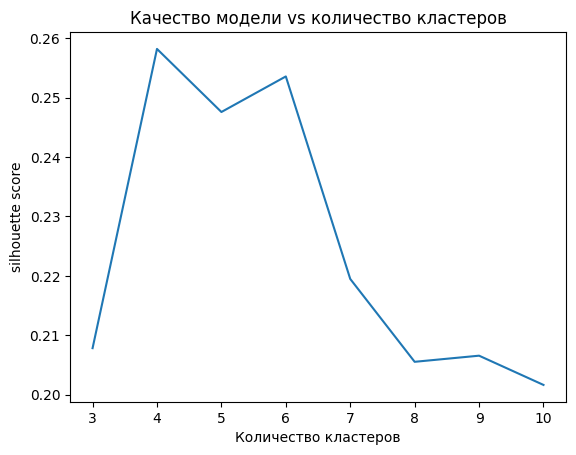

In [ ]:
g = sns.lineplot(x=model_params, y=results)
g.set_xlabel("Количество кластеров")
g.set_ylabel("silhouette score")
g.set_title("Качество модели vs количество кластеров");

## Задача 4. Обучение K-MEANS (2/8)


Обучите Kmeans с оптимальным количеством кластеров (не забудьте random_state=42, n_init=1). В исходный датасет добавьте колонку `clusters` с номером кластера, подобранного алгоритмом, для каждого наблюдения.

Постройте bar chart и таблицу распределения пользователей по кластерам.

Какое минимальное количество наблюдений попало в один кластер?

In [ ]:
kmeans.set_params(n_clusters=4)
labels = kmeans.fit_predict(df_)

In [ ]:
df_['clusters'] = labels

In [ ]:
df_.clusters.value_counts().sort_values()

,count
clusters,
2,2015
1,7252
3,8569
0,11927


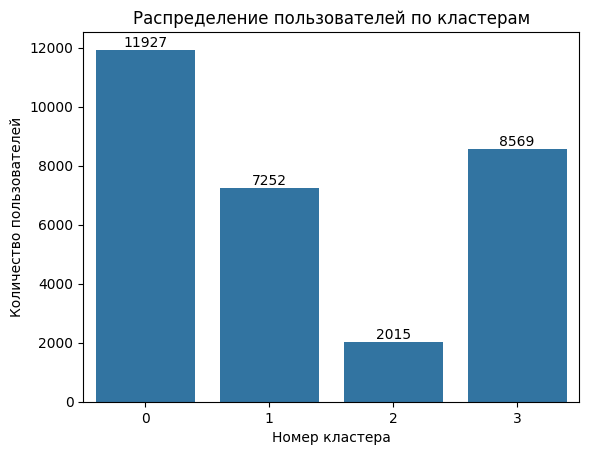

In [ ]:
g = sns.barplot(x=df_.clusters.value_counts().index, y=df_.clusters.value_counts(),)
g.bar_label(g.containers[0]);
g.set_xlabel("Номер кластера")
g.set_ylabel("Количество пользователей")
g.set_title("Распределение пользователей по кластерам");

## Задача 4. Обучение K-MEANS (3/8)


Распределение кластеров выглядит уже более адекватно. Давайте попробуем проанализировать получившиеся кластеры

Здесь и далее для анализа кластеров будем использовать опять среднюю цену вместо ее логарифма, тк так будет легче интерпретировать

Для признаков `'n_ads', 'mean_price', 'n_types', 'days_ago', 'mean_n_years', 'buyer'` посчитайте их среднее для каждого кластера.

In [ ]:
df['mean_price'] = data.mean_price

In [ ]:
df1 = df.loc[df_.index].drop('mean_log_price', axis=1)

In [ ]:
df1["clusters"] = labels

In [ ]:
df1.groupby("clusters").mean()

,n_ads,n_types,days_ago,mean_n_years,buyer,mean_price
clusters,,,,,,
0,3.058355,2.282217,228.992370,22.576476,0.003521,3.034001e+05
1,2.538058,4.271925,287.532819,16.361027,1.000000,9.578379e+05
2,22.249628,4.583623,345.472953,17.406206,0.098759,7.480136e+05
3,2.991248,4.612090,248.161279,10.144616,0.002217,1.571562e+06


## Задача 4. Обучение K-MEANS (4/8)


В какой кластер попали пользователи, которые зарегистрированы значительно раньше остальных?

<Axes: xlabel='clusters', ylabel='days_ago'>

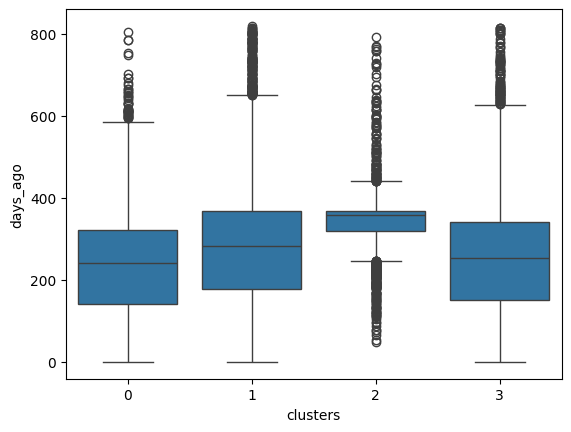

In [ ]:
sns.boxplot(x=df1.clusters, y=df1.days_ago)

## Задача 4. Обучение K-MEANS (5/8)


В каком кластере исключительно те пользователи, которые чаще покупали, чем продавали автомобили?

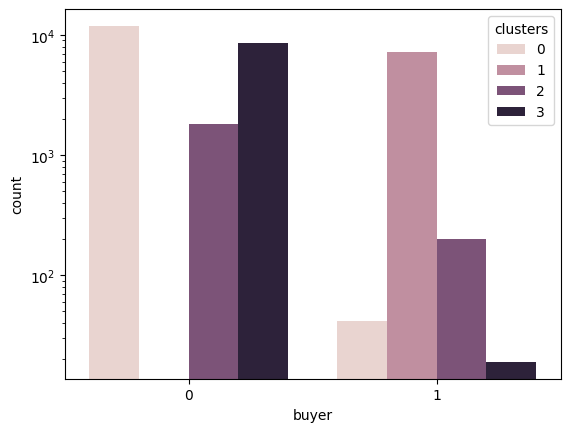

In [ ]:
g = sns.countplot(data=df1, x='buyer', hue='clusters', )
g.set_yscale('log')

## Задача 4. Обучение K-MEANS (6/8)


В каком кластере продавцы / покупатели самых дешевых автомобилей?

<Axes: xlabel='clusters', ylabel='mean_price'>

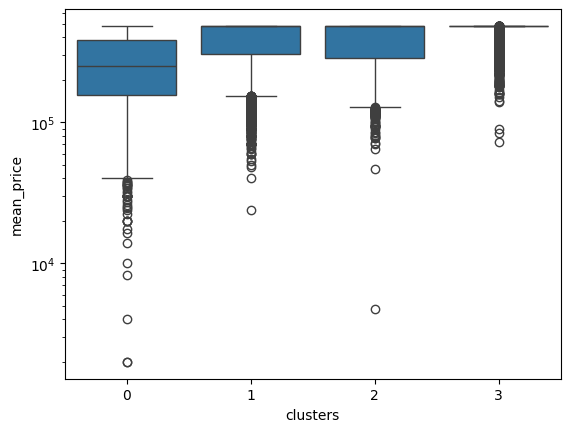

In [ ]:
sns.boxplot(x=df1.clusters, y=df1.mean_price.clip(upper=df1.mean_price.median()), log_scale=True)

## Задача 4. Обучение K-MEANS (7/8)


В каком кластере пользователи, которые разместили в среднем больше всего объявлений?

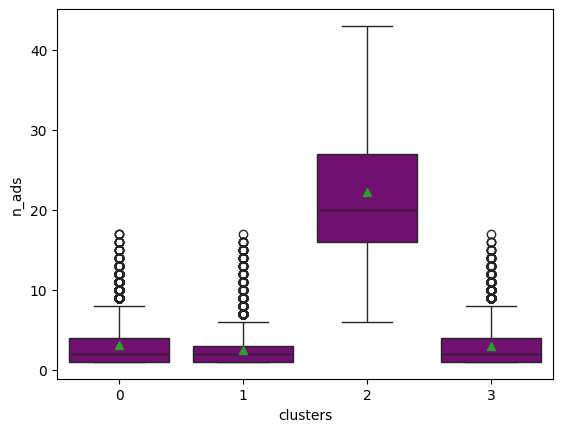

In [ ]:
sns.boxplot(data=df1, x='clusters', y='n_ads', showmeans=True, color='purple');

## Задача 5. Визуализация (1/3)


Понизьте размерность пространства фичей до 3 с помощью `PCA`. Как на лекции, постройте матрицу корреляций (sns.heatmap) между компонентами и фичами (нужно брать фичи, которые мы использовали для кластеризации (логарифм цены и отскалированные значения)

В `PCA` нужно задать параметр `random_state=42`

Назовите признак у которого самая высокая положительная корреляция среди всех компонент `PCA`?

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
df_pca = df_.drop('clusters', axis=1)
# Важно сбросить индекс, иначе корреляция не сработает
df_pca.reset_index(drop=True, inplace=True)

In [ ]:
pca = PCA(n_components=3, random_state=42)
pca.fit(df_pca)

PCA(n_components=3, random_state=42)

In [ ]:
data_pca = pd.DataFrame(pca.transform(df_pca), columns=[f"PCA_{i}" for i in range(1, 4)])
data_pca

,PCA_1,PCA_2,PCA_3
0,3.700069,4.181833,3.966882
1,2.391656,1.259064,0.255868
2,0.752460,-1.387330,-1.209656
3,0.655049,-1.818352,0.898968
4,1.661555,-1.373332,1.080243
...,...,...,...
29758,-0.997677,-1.999364,0.598127
29759,-1.591474,-0.858474,-1.863920
29760,0.186328,-1.765295,0.467390
29761,-0.690984,-1.765551,0.461491


In [ ]:
### Мы можем посмотреть на доли дисперсий, которые объясняет каждая из компонент
pca.explained_variance_ratio_

array([0.29865068, 0.22025376, 0.18006018])

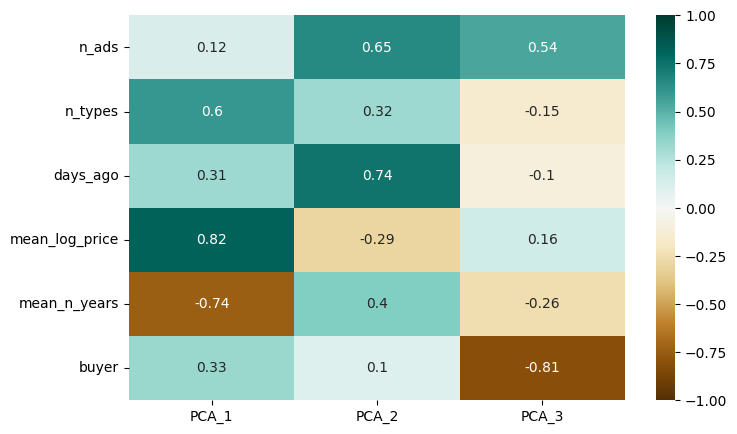

In [ ]:
### Также можно изучить "состав" этих компонент - изучив корреляцию с базовыми признаками
### В начале - корреляции под каждую компоненту с фичами
fst_component_corr = df_pca.corrwith(data_pca.PCA_1)
scnd_component_corr = df_pca.corrwith(data_pca.PCA_2)
thrd_component_corr = df_pca.corrwith(data_pca.PCA_3)


### Объединим все в одно место
corrs = pd.concat(
    (
        fst_component_corr,
        scnd_component_corr,
        thrd_component_corr,
    ),
    axis=1
)

### Нормально назовем колонки
corrs.columns = [f"PCA_{i}" for i in range(1, 4)]

### Изобразим в виде карты
fig = plt.figure()
fig.set_size_inches(8, 5)

sns.heatmap(corrs,
            xticklabels=corrs.columns,
            yticklabels=corrs.index,
            cmap='BrBG',
            vmin=-1,
            vmax=1,
            annot=True)

plt.show()

## Задача 5. Визуализация (3/3)


Разметите результат работы KMeans в координатах главных компонент.

Видно ли на графике, как разделены кластеры? Можно их четко разделить?

In [ ]:
data_pca['clusters'] = labels

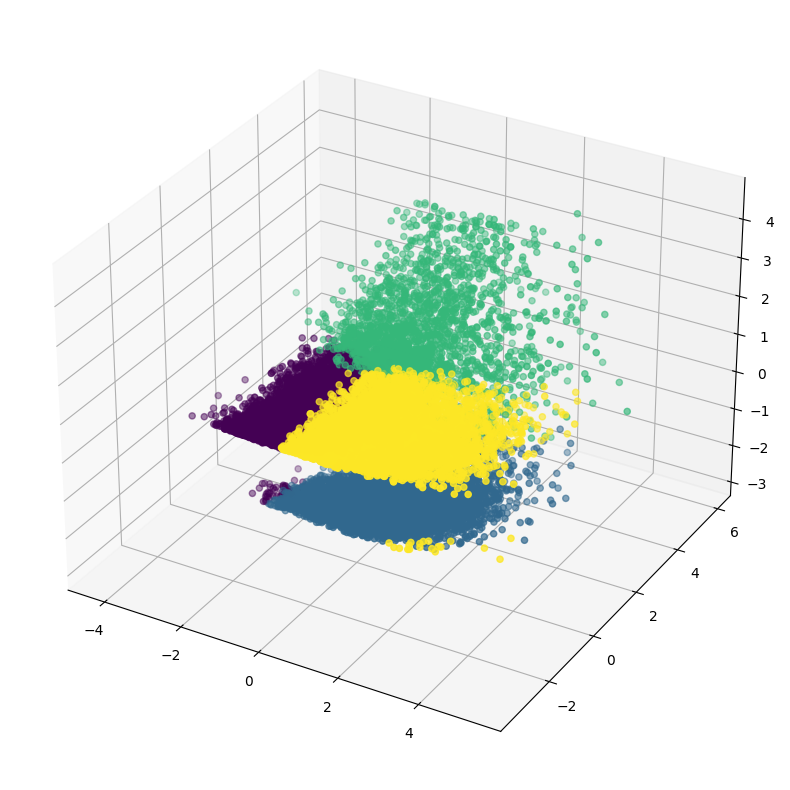

In [ ]:

fig = plt.figure()
fig.set_size_inches(16, 10)

ax = plt.axes(projection='3d')
ax.scatter3D(
    data_pca['PCA_1'],
    data_pca['PCA_2'],
    data_pca['PCA_3'],
    c = data_pca['clusters']
);

In [ ]:
import plotly.express as px

fig = px.scatter_3d(data_pca, x="PCA_1", y="PCA_2", z="PCA_3", color="clusters")
fig.show()